# 1. Motivation

1. valid, test set을 보면 제목만 주어지고 songs나 tags에 대한 정보가 전혀 없는 경우가 있습니다. 
2. 때문에 플레이리스트 제목을 활용해보고 싶습니다.

3. 제목은 매우 유용한 정보입니다. 
4. **Tags와** 플레이리스트를 같이 보다보면 제목에 있는 단어를 그대로 태그로 붙이는 경우가 많이 있기 때문입니다.



아래 셀에서 간단히 확인해 봅시다.

In [0]:
import pandas as pd
# data_path = your_path
train = pd.read_json(data_path + 'train.json')
val = pd.read_json(data_path + 'val.json')

In [4]:
# 1을 확인해 볼 수 있습니다.
val[(val['tags'] + val['songs']).map(len) == 0]

,tags,id,plylst_title,songs,like_cnt,updt_date
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000
9,[],142007,기분 좋은 재즈와 함께 만드는 달달한 하루,[],0,2015-06-22 09:11:02.000
35,[],65114,"■■■■ 사랑,그리고이별 ■■■■",[],6,2010-10-27 10:34:34.000
57,[],87700,마쉬멜로우같은 멜로우한 음악,[],6,2016-01-14 10:19:30.000
71,[],35271,공부와 독서를 위한 #Newage,[],10,2020-01-17 15:46:20.000
...,...,...,...,...,...,...
22903,[],140513,10년이 지나 들어도 좋은 감성 Ballad,[],405,2016-01-11 10:58:05.000
22920,[],124704,가사의 의미와 뜻은모른다!! 오직 멜로디로만 선곡한 팝송!!,[],27,2016-02-05 12:31:59.000
22981,[],13045,＊카페 느낌 샹송♭,[],38,2011-07-12 00:58:39.000
22991,[],32537,컨트리 황제 조니 캐시가 선 레코드 시절 발표한 초기 대표작,[],28,2019-06-17 14:22:48.000


In [6]:
# 4를 확인해 볼 수 있습니다.
train.tail()

,tags,id,plylst_title,songs,like_cnt,updt_date
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000
115070,"[노래추천, 팝송추천, 팝송, 팝송모음]",100389,FAVORITE POPSONG!!!,"[26008, 456354, 324105, 89871, 135272, 143548,...",17,2020-04-18 20:35:06.000


- `퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP`

- `#1. 눈물이 앞을 가리는 나의_이야기`

같은 경우를 보면 4를 확인해 볼 수 있습니다.

**Khaiii Tokenizer**를 활용하여 제목에서 유용한 단어를 추출해 봅니다.

다음 셀을 실행하면 코랩에서 설치됩니다. **시간이 꽤 걸립니다.**

In [0]:
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

# 2. 정답 Tags에서 자주 사용되는 품사 확인
- 정답에서 형태소 분석을 하여 단어를 추출하고 싶습니다.
- 그러나 모든 형태소가 추측에 도움을 주지는 않습니다.
- 조사나 접속사 같은 불용어나 특수기호는 제거하고 싶습니다.
- 어떤 품사가 태그 예측에 도움이 되는지 확인하기 위해 정답 Tag의 품사를 확인해 봅니다.

In [0]:
import json
import re
from collections import Counter
from typing import *

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
from khaiii import KhaiiiApi  # khaiii 레포는 https://github.com/kakao/khaiii 이쪽

In [0]:
def re_sub(series: pd.Series) -> pd.Series:
    series = series.str.replace(pat=r'[ㄱ-ㅎ]', repl=r'', regex=True)  # ㅋ 제거용
    series = series.str.replace(pat=r'[^\w\s]', repl=r'', regex=True)  # 특수문자 제거
    series = series.str.replace(pat=r'[ ]{2,}', repl=r' ', regex=True)  # 공백 제거
    series = series.str.replace(pat=r'[\u3000]+', repl=r'', regex=True)  # u3000 제거
    return series

def flatten(list_of_list : List) -> List:
    flatten = [j for i in list_of_list for j in i]
    return flatten

def get_token(title: str, tokenizer)-> List[Tuple]:
    
    if len(title)== 0 or title== ' ':  # 제목이 공백인 경우 tokenizer에러 발생
        return []
    
    result = tokenizer.analyze(title)
    result = [(morph.lex, morph.tag) for split in result for morph in split.morphs]  # (형태소, 품사) 튜플의 리스트
    return result

def get_all_tags(df) -> List:
    tag_list = df['tags'].values.tolist()
    tag_list = flatten(tag_list)
    return tag_list

In [0]:
tokenizer = KhaiiiApi()
all_tag = get_all_tags(train)
token_tag = [get_token(x, tokenizer) for x in all_tag]  # 태그를 형태소 분석

In [11]:
token_tag[:10]

[[('락', 'MAG')],
 [('추억', 'NNG')],
 [('회상', 'NNG')],
 [('까페', 'NNG')],
 [('잔잔', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')],
 [('연말', 'NNG')],
 [('눈', 'NNG'), ('오', 'VV'), ('는', 'ETM'), ('날', 'NNG')],
 [('캐럴', 'NNG')],
 [('분위기', 'NNG')],
 [('따듯', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')]]

In [12]:
train.head(5)

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000


In [0]:
token_itself = list(filter(lambda x: len(x)==1, token_tag))  # 태그 자체가 형태소여서 분리되지 않는 태그만 골라봅니다
token_itself = flatten(token_itself)
flatten_token = flatten(token_tag)

In [14]:
print('%-23s'%'# of original tag is', f'{len(all_tag):8,}')
print('%-23s'%'# of morpheme itself is', f'{len(token_itself):8,}')
print('%-23s'%'# of total token is', f'{len(flatten_token):8,}')

# of original tag is     476,331
# of morpheme itself is  333,093
# of total token is      722,860


In [0]:
# Counting Part of Speech (pos)
pos = [x[1] for x in token_itself]
pos_count = Counter(pos)
popular_pos = pos_count.most_common()

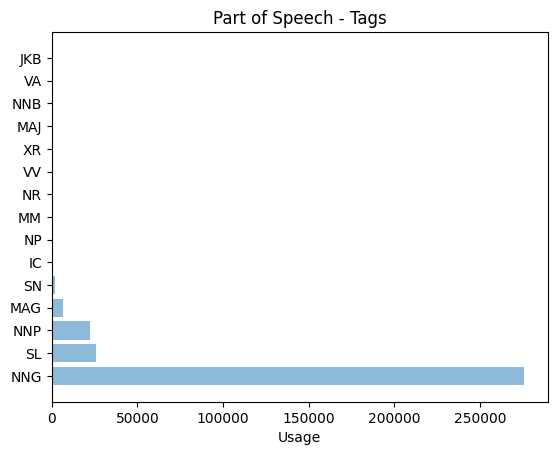

In [16]:
# tag 분류표는 https://github.com/kakao/khaiii/wiki/%EC%BD%94%ED%8D%BC%EC%8A%A4 를 참고
objects = [x[0] for x in popular_pos]
y_pos = np.arange(len(objects))
performance = [x[1] for x in popular_pos]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Part of Speech - Tags')

plt.show()

# 3. 플레이스리스트 제목을 형태소 분석
- NNG, SL, NNP, MAG,SN가 압도적으로 많습니다.
- 각각 일반 명사, 외국어, 고유 명사, 일반 부사, 숫자 입니다.
- 확인해 보면 숫자의 경우 7080, 2000 같은 태그가 꽤 있습니다.
- 제목을 형태소 분석한 결과가 위의 품사인 경우에만 남겨두겠습니다.

In [0]:
train['plylst_title'] = re_sub(train['plylst_title'])
train.loc[:, 'ply_token'] = train['plylst_title'].map(lambda x: get_token(x, tokenizer))

In [0]:
using_pos = ['NNG','SL','NNP','MAG','SN']  # 일반 명사, 외국어, 고유 명사, 일반 부사, 숫자
train['ply_token'] = train['ply_token'].map(lambda x: list(filter(lambda x: x[1] in using_pos, x)))

In [0]:
unique_tag = set(token_itself)
unique_word = [x[0] for x in unique_tag]

In [20]:
# 우리의 목적은 정답 tags를 맞추는 것이기 때문에 정답 tags에 나온 형태소만 남겨둡니다.
train['ply_token'] = train['ply_token'].map(lambda x: list(filter(lambda x: x[0] in unique_word, x)))
train.head(10)

,tags,id,plylst_title,songs,like_cnt,updt_date,ply_token
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"[(여행, NNG), (음악, NNG)]"
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"[(요즘, NNG), (말, NNG)]"
2,"[까페, 잔잔한]",76951,편하게 잔잔하게 들을 수 있는 곡,"[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"[(곡, NNG)]"
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"[(크리스마스, NNG), (분위기, NNG), (흠뻑, MAG)]"
4,[댄스],27616,추억의 노래,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"[(추억, NNG), (노래, NNG)]"
5,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...",69252,2017 Pop Trend,"[418694, 222305, 96545, 135950, 304687, 457451...",435,2017-09-15 15:59:26.000,"[(2017, SN), (Pop, SL)]"
6,"[짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]",45339,짝사랑고백사랑이별슬픔 감성을 자극하는곡들,"[528130, 505036, 398947, 627363, 37748, 376358...",24,2016-10-24 21:30:17.000,"[(짝사랑, NNG), (감성, NNG), (자극, NNG), (곡, NNG)]"
7,"[잔잔한, 추억, 회상]",36557,멍청이 내맘도 몰라,"[496913, 632529, 501426, 515574, 411161, 10341...",5,2008-09-23 22:32:02.000,"[(맘, NNG)]"
8,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]",70741,DANCING IN THE MOONLIGHT 01,"[634861, 270738, 163936, 692209, 449477, 56342...",0,2019-11-30 21:17:59.000,"[(01, SN)]"
9,"[록, Metal, 이일우, M에센셜, 메탈, Rock, 락]",10288,록메탈 Written by 이일우,"[613315, 439294, 230806, 497932, 113479, 93506...",7,2016-06-17 18:23:54.000,"[(록메탈, NNP), (이일우, NNP)]"


# 4. Valid Set에 적용
- 이제 Valid Set에 적용하고 제출해 봅니다. 
- 제목을 형태소 분석하고 필터링한 태그만 남겨두고 
- 나머지는 제일 많이 나온 Tag로 채웁니다.
- Valid Set에는 제목조차 없는 경우가 꽤 많아서 아쉽습니다.

In [0]:
val['plylst_title'] = re_sub(val['plylst_title'])
val.loc[:, 'ply_token'] = val['plylst_title'].map(lambda x: get_token(x, tokenizer))
val['ply_token'] = val['ply_token'].map(lambda x: list(filter(lambda x: x[1] in using_pos, x)))
val['ply_token'] = val['ply_token'].map(lambda x: list(filter(lambda x: x[0] in unique_word, x)))
val['predict_tag'] = val['ply_token'].map(lambda x: [tag[0] for tag in x])

In [22]:
# 추출된 태그가 1개 이상인 경우를 봅니다. 
val['predict_len'] = val['predict_tag'].map(len)
val[val['predict_len']>0][['tags', 'predict_tag', 'plylst_title']]

,tags,predict_tag,plylst_title
8,[스트레스],"[운동, 스트레스, 날]",리듬타면서 빡시게 운동하자스트레스 날리자
9,[],"[기분, 재즈, 함께, 달, 하루]",기분 좋은 재즈와 함께 만드는 달달한 하루
17,[생각나],"[다시, 사람]",다시 생각나는 그 사람
20,"[피아노, 이루마, 메로디]","[불면증, 곡들]",불면증엔 아름다운 뉴에이지 곡들
35,[],[별],사랑그리고이별
...,...,...,...
22981,[],"[카페, 느낌, 샹송]",카페 느낌 샹송
22991,[],"[컨트리, 황제, 레코드, 시절, 초기]",컨트리 황제 조니 캐시가 선 레코드 시절 발표한 초기 대표작
22992,[사랑],[음악],옷차림이 가벼워질때 부담없이 듣는음악
22996,[],"[해, 밤]",해 저무는 밤


In [0]:
val['predict_tag'] = val.apply(lambda x: [tag for tag in x.predict_tag if tag not in x.tags], axis=1)  # 이미 정답에 있는 건 제외

In [0]:
# 나머지는 제일 많이 나온 태그로 채웁니다
tag_count = Counter(all_tag)
popular_tag = tag_count.most_common(10)
popular_tag = [x[0] for x in popular_tag]

In [0]:
# 제출 코드
val['tags'] = val['predict_tag'].map(lambda x: x+ popular_tag)
val['tags'] = val['tags'].map(lambda x: list(dict.fromkeys(x)))
val['tags'] = val['tags'].map(lambda x: x[:10])
# songs도 일단 아무 숫자나 넣습니다
val['songs'] = [list(range(100))] * len(val)

In [0]:
def submission(df):
    final = df[['id', 'songs', 'tags']].to_dict('index')
    final = [i for i in final.values()]
    with open(data_path+'results/results.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(final, ensure_ascii=False))
    !cd  "/content/drive/My Drive/melon/results/" && zip results.zip results.json

In [27]:
submission(val)

updating: results.json (deflated 98%)


- 이렇게 제출한 결과 태그 정확도에서 0.169805 를 얻었습니다.
- Baseline인 Global Most Popular 에서는 0.161075 입니다.
- 이렇게만으로는 큰 성능 개선이 어렵습니다.

# 5. 추가로 시도해볼 것들

- Tags들을 보면 잔잔한, 시원한, 신나는 같은 (어근 + 한,는) 같은 조합이 많습니다.
- 그러나 위에서는 형태소 분석을 했기 때문에 아래와 같은 결과를 얻습니다.
- 이런 부분을 보완할 방법을 생각해봐야 합니다.

In [28]:
get_token('시원한 노래', tokenizer)

[('시원', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM'), ('노래', 'NNG')]

- ita9naiwa님이 [올려주신 자료](https://arena.kakao.com/forum/topics/200)에 추가적인 정보로 형태소 분석된 태그를 추가하는 방법도 생각해 볼 수 있습니다.

- 이 방법으로 cold-start 문제를 조금이나마 완화할 수 있을 것으로 기대 됩니다.